Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 24.  Winter 2026.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd

We'll demonstrate two ensemble methods---bagging and random forests.  We'll tackle a classification problem.  Our data set contains the SMILES strings for molecules and a binary variable for whether that molecule is toxic to honeybees or not.  As pollinators, honeybees are critical to the environment and agriculture.  As their populations are decreasing, it is critical to identify agriculatural chemicals (herbicides, pesticides, fertilizers) that do not kill bees.  This data set is adapted from : <url>https://pubs.aip.org/aip/jcp/article-abstract/157/3/034102/2841476/Classifying-the-toxicity-of-pesticides-to-honey</url>.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture24/bee_toxicity.csv')
df.head()

,Outcome,SMILES,Set
0,Nontoxic,CCNc1nc(CC)c(C(=O)NC(C#N)c2cccs2)s1,Modeling
1,Toxic,CCOP(=S)(OCC)Oc1cc(C)nc(C(C)C)n1,Modeling
2,Nontoxic,CC1CN(C2CCCCCCCCCCC2)CC(C)O1,Modeling
3,Nontoxic,O=C(NC(=O)c1c(F)cccc1F)Nc1ccc(Oc2ccc(C(F)(F)F)...,Modeling
4,Nontoxic,Clc1ccccc1-c1nnc(-c2ccccc2Cl)nn1,Modeling


We'll use our old friends <code>rdkit</code> and <code>mordred</code> to featurize the molecules based on the SMILES string.

In [3]:
!pip install rdkit
!pip install mordredcommunity
import rdkit
import mordred, mordred.descriptors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.1 MB/s eta 0:00:00


Our labels will be the <code>'Outcome'</code>, which is <code>'Nontoxic'</code> or <code>Toxic</code>.  We'll build numerical features with <code>mordred</code> and then standardize the features.  We have to clean these features, by removing features with <code>nan</code> values or missing string values.  We then standardize the features.

In [4]:
#the targets are the 'Nontoxic' or 'Toxic' labels
y_train = df['Outcome']

#make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)

#build rdkit objects for each molecule from the SMILES strings
molecules_train = [rdkit.Chem.MolFromSmiles(s) for s in df['SMILES']]

#calculate the features for each molecule
features_train = calc.pandas(molecules_train)

#clean the features
#only keep features that are numbers
cleaned_features_train = pd.DataFrame(features_train).select_dtypes(include=['number'])
#remove any features with missing or NaN values
cleaned_features_train.dropna(axis=1, inplace=True)
#remove any features that just have a single value
cleaned_features_train = cleaned_features_train.loc[:, cleaned_features_train.nunique() > 1]

#save the feature names
feature_names = cleaned_features_train.columns

#standardize the features
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(cleaned_features_train)

100%|██████████| 382/382 [01:02<00:00,  6.12it/s]


This is way too many features for a demonstration.  Let's do PCA with 20 principal components.  We'll use thse 20 principal componenets as our features for classification.

Total explained variance: 79.36 %


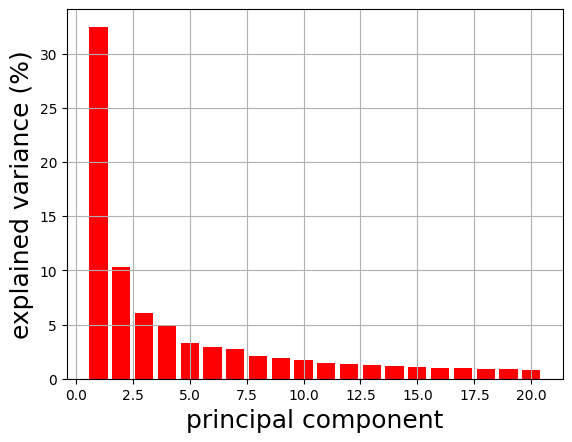

In [5]:
#get the first 20 principal components
pca = sklearn.decomposition.PCA(n_components=20)
PCs = pca.fit_transform(X_train)

#print the total explained variance for these components
print('Total explained variance:', np.round(100.0*np.sum(pca.explained_variance_ratio_),decimals=2),'%')

#explained variance plot gives the fraction of variance explained by each principal component
fig1,ax1 = plt.subplots()
ax1.bar(range(1, len(pca.explained_variance_ratio_)+1), 100.0*pca.explained_variance_ratio_, color='r')
ax1.set_xlabel('principal component', fontsize=18)
ax1.set_ylabel('explained variance (%)', fontsize=18)
ax1.grid()
plt.show()

To give us a baseline measure of performance, we'll fit a single decision tree.  We'll let the tree overfit- it will train for as much depth as it needs.  We'll then estimate the test error with 10-fold cross-validation.

In [6]:
#base decision treeperformance

#set up the k-fold cross validation with k=10
kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)

#set up the decision tree
tree = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=None)

#this will apply the cross validation automatically and put the results in 'cv_results'
cv_results = sklearn.model_selection.cross_validate(tree, PCs, y_train, cv=kf, scoring='accuracy', return_train_score=True)

#collect the errors from the validation
training_acc = np.mean(cv_results['train_score'])
validation_acc = np.mean(cv_results['test_score'])

print('Training accuracy:', np.round(100.0*training_acc, decimals=2),'%')
print('Validation accuracy:', np.round(100.0*validation_acc, decimals=2),'%')


Training accuracy: 100.0 %
Validation accuracy: 74.55 %


# **Bagging**

With bagging we will build an ensemble of many trees and make our final classification with a vote from all of the trees.  We build these different trees by drawing randomly from our test data and training a tree on this random draw.  During bagging we draw random samples with replacement until our new random data set has the same number of data points as the original training set.

Bagging is a general procedure.  While we are using it with a decision tree here, it can be used with most machine learning models to build an ensemble of models.  The number of bags/trees is a hyperparameter.  Below we'll evaluate a range of values and pick the best using cross-validation to estimate the error.

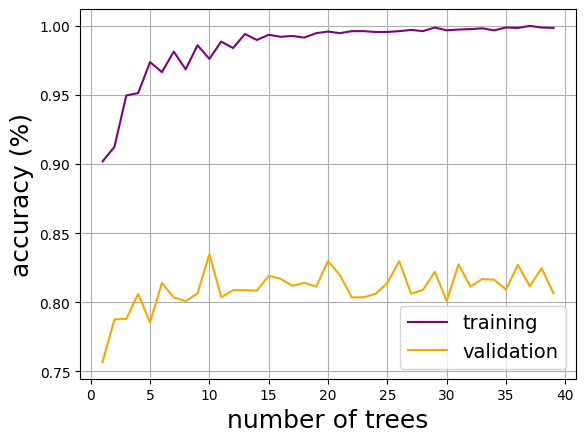

In [7]:
#test of range of bags/trees
number = np.arange(1, 40)

training_accuracies = []
validation_accuracies = []

for n in number:
  #set up the k-fold cross validation with k=10
  kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)

  #set up the decision tree as the base model
  tree = sklearn.tree.DecisionTreeClassifier(criterion='gini')

  #set up the bagging
  #estimator is the base model, here we are using a decision tree, but bagging can be used with any machine learning model
  #max_features=1.0 means to consider 100% of the features in each split
  #bootstrap=True means to draw from the training data with replacement until it is the same number of data points as the training data
  #n_estimators is the number of bags or trees we want
  bagging = sklearn.ensemble.BaggingClassifier(estimator=tree, n_estimators=n, max_features=1.0, bootstrap=True)

  #this will apply the cross validation automatically and put the results in 'cv_results'
  cv_results = sklearn.model_selection.cross_validate(bagging, PCs, y_train, cv=kf, scoring='accuracy', return_train_score=True)

  #collect the errors from the validation
  #since the scores are the negative of MSE, we multiply by -1 to get the MSE
  training_acc = np.mean(cv_results['train_score'])
  validation_acc = np.mean(cv_results['test_score'])

  training_accuracies.append(training_acc)
  validation_accuracies.append(validation_acc)

fig,ax = plt.subplots()
ax.plot(number, training_accuracies, color='purple', label='training')
ax.plot(number, validation_accuracies, color='orange', label='validation')
ax.legend(fontsize=14)
ax.set_xlabel('number of trees',fontsize=18)
ax.set_ylabel('accuracy (%)',fontsize=18)
ax.grid()
plt.show()

The best ensemble will be the one with the highest validation accuracy.

In [8]:
print('Best number of trees:', np.argmax(validation_accuracies)+1)
print('Validation accuracy:', np.round(100.0*validation_accuracies[np.argmax(validation_accuracies)], decimals=2),'%')

Best number of trees: 10
Validation accuracy: 83.48 %


We've gotten a pretty good boost in accuracy compared to the single tree!

# **Random Forests**

After bagging, our ensemble of trees can be highly correlated, meaning they can look very similar.  To take advantage of the statistical power of an ensemble, each member should be independent, or de-correlated from the others.  To increase their independence, we'll use a random forest.  A random forest is bagging plus when training our trees we only consider a random subset of $m$ features from our $p$ total features.  A popular choice is $m=\sqrt{p}$.  With 20 features here from PCA this means we'll randomly choose 4 features to consider at each split.  This will result in more varied trees.

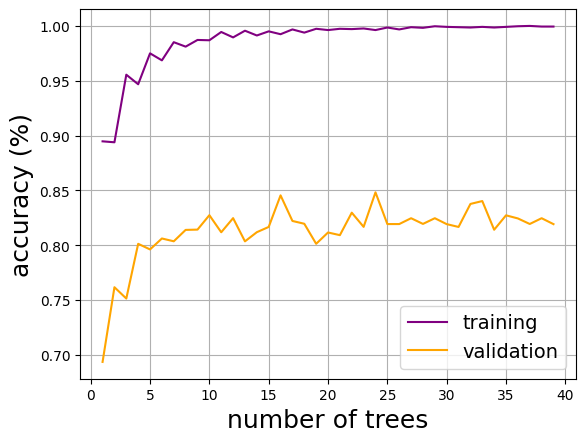

In [9]:
#test of range of bags/trees
number = np.arange(1, 40)

training_accuracies = []
validation_accuracies = []

for n in number:
  #set up the k-fold cross validation with k=10
  kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True)

  #set up the random forest
  #max_features='sqrt' means we'll randomly consider approximately the square root of the total number of features at each split
  #bootstrap=True means to draw from the training data with replacement until it is the same number of data points as the training data
  #n_estimators is the number of bags or trees we want
  random_forest = sklearn.ensemble.RandomForestClassifier(criterion='gini', n_estimators=n, max_features='sqrt', bootstrap=True)

  #this will apply the cross validation automatically and put the results in 'cv_results'
  #the scoring is the negative of the mean squared error
  cv_results = sklearn.model_selection.cross_validate(random_forest, PCs, y_train, cv=kf, scoring='accuracy', return_train_score=True)

  #collect the errors from the validation
  #since the scores are the negative of MSE, we multiply by -1 to get the MSE
  training_acc = np.mean(cv_results['train_score'])
  validation_acc = np.mean(cv_results['test_score'])

  training_accuracies.append(training_acc)
  validation_accuracies.append(validation_acc)

fig,ax = plt.subplots()
ax.plot(number, training_accuracies, color='purple', label='training')
ax.plot(number, validation_accuracies, color='orange', label='validation')
ax.legend()
ax.legend(fontsize=14)
ax.set_xlabel('number of trees',fontsize=18)
ax.set_ylabel('accuracy (%)',fontsize=18)
ax.grid()
plt.show()

Let's check our best ensemble again.

In [10]:
print('Best number of trees:', np.argmax(validation_accuracies)+1)
print('Validation accuracy:', np.round(100.0*validation_accuracies[np.argmax(validation_accuracies)], decimals=2),'%')

Best number of trees: 24
Validation accuracy: 84.82 %


We've got a slight boost in performance with the random forest, but it's about the same.